# Overview Plots

This notebook makes several of the manuscript figures providing an overview of the idealized numerical simulation in the CFB on EBF manuscript.

- Figure 1: Fancy 3 panel plot of SST, vorticity, and perturbation stress.
- Figure 3: Histograms of vorticity, strain, divergence.
- Figure 5: Zoom in on eddy.

Author: Jacob Wenegrat (wenegrat@umd.edu) 2/2021


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import xgcm
from glob import glob
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer
#%%
# plt.rcParams['text.usetex'] = True
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  

import cmocean.cm as cmo

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [3]:
## LOAD THE MODEL RUNS

# For some reason this fails the first time I try to run it, but works after trying again...

reload(lruns)
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks={'time':1})


reload(lruns)
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, grid = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks={'time':1})

## Calculations

In [4]:
# Vorticity Calculation
vx = grid.derivative(dsNC.v, 'X')
uy = grid.derivative(dsNC.u, 'Y')
vy = grid.derivative(dsNC.v, 'Y', boundary='extend')
ux = grid.derivative(dsNC.u, 'X', boundary='extend')

dsNC['vort'] = vx - uy #psi points
dsNC['div'] = vy + ux  #rho points
dsNC['strain'] = np.sqrt((xroms.to_rho(ux, grid)-xroms.to_rho(vy,grid))**2 + (xroms.to_rho(vx,grid) + xroms.to_rho(uy,grid))**2)

vx = grid.derivative(dsWC.v, 'X')
uy = grid.derivative(dsWC.u, 'Y')
vy = grid.derivative(dsWC.v, 'Y', boundary='extend')
ux = grid.derivative(dsWC.u, 'X', boundary='extend')

dsWC['vort'] = vx - uy
dsWC['div'] = vy + ux
dsWC['strain'] = vy - ux # Note the alternate possible strain rate def (below)
dsWC['strain'] = np.sqrt((xroms.to_rho(ux, grid)-xroms.to_rho(vy,grid))**2 + (xroms.to_rho(vx,grid) + xroms.to_rho(uy,grid))**2)

In [5]:
# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), grid)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['JF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020*(dsWC.hbl+1))
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020)
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*grid.derivative(dsNC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), grid)
dsNC['bx'] = bx
dsNC['by'] = by
dsNC['JF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020*(dsNC.hbl+1))
dsNC['EBF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020)
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)

## 3 Panel Overview Plot

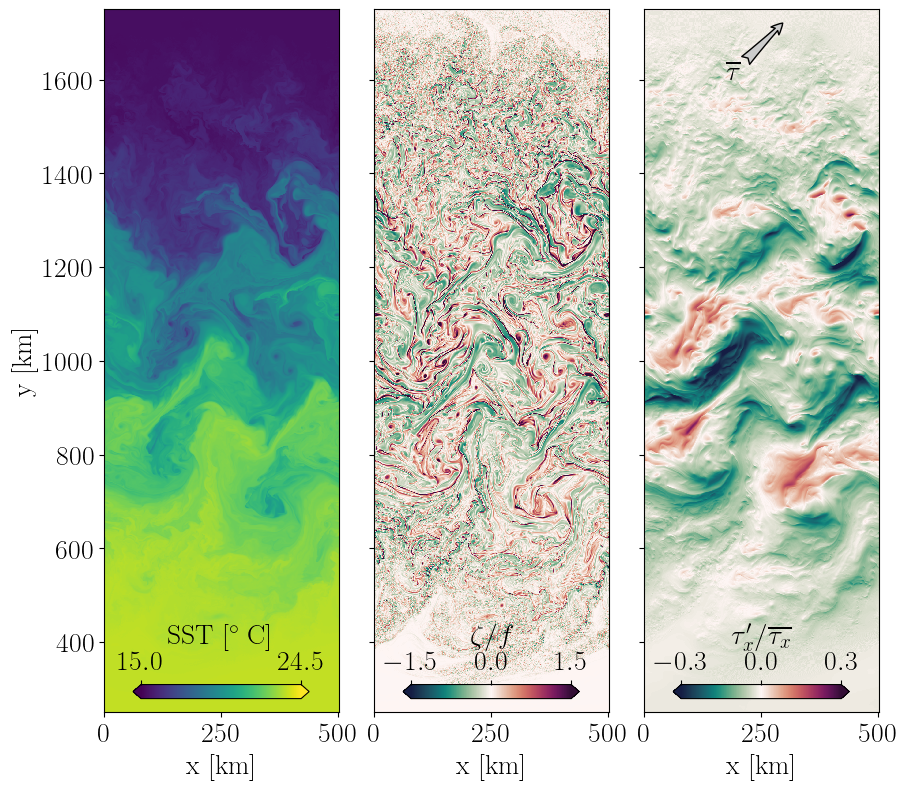

In [8]:
# Nice side-by-side SST, vorticity, stress perturbation plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
#plt.rcParams.update({
#    "text.usetex": False,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Computer Modern Serif"]})

#plt.rcParams['mathtext.fontset']='cm'

rs = True
# Plot Vorticity
#Day = 200
#Day = 185
Day = 360+25
fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=True)


# Divergence
#divnorm = dsWC.div.isel(s_rho=-3).sel(ocean_time=Day*86400)/dsWC.f
#ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, divnorm, vmin=-1, vmax=1, cmap = cmo.curl)

#ax[2].set_ylim(300, 1900)
#ax[2].set_aspect('equal')


# Iterate through subplots
for i in range(0,3):
    if i==0:
        vl = 16
        vr = 24
        vl = 15
        vr = 24.5
        ix = ax[0].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
        label=r'SST [$^\circ$ C]'
    elif i==1:
        vl = -1.5
        vr = 1.5
        vortnorm = xroms.to_rho(dsWC.vort.isel(s_rho=-1).sel(ocean_time=Day*86400), grid)/dsWC.f
        ix = ax[1].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, vortnorm, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs)
        label=r'$\zeta/f$'
    else:
        vl = -0.3
        vr = 0.3
        label = r'$\tau_x^\prime/\overline{\tau_x}$'
        txmag = (1e-3*np.sqrt(2*5**2)*5)
        txpert = (dsWC.sustr.sel(ocean_time=Day*86400) - txmag)/txmag
        txpert = xroms.to_rho(txpert, grid)
        ix = ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, txpert, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs)

    ax[i].set_ylim(400, 1800)
    ax[i].set_ylim(250, 1750)

    ax[i].set_aspect('equal')

    axins = inset_axes(ax[i],
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='lower center')
    cb = plt.colorbar(ix, ax=ax[i], cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
    cb.set_label(label, labelpad=5)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    ax[i].set_xticks([0, 250, 500])

ax[0].set_ylabel('y [km]')
ax[0].set_xlabel('x [km]')
ax[1].set_xlabel('x [km]')
ax[2].set_xlabel('x [km]')

#cf = 100 # 20 is 10 km
#xslice = slice(0, 1000, cf)
#yslice = slice(0, 4000, cf)
#suc = xroms.to_rho(dsWC.sustr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
#svc = xroms.to_rho(dsWC.svstr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
#xrhoc = dsWC.x_rho.isel(xi_rho=xslice, eta_rho=yslice)

#ax[2].quiver(xrhoc.x_rho/1000, xrhoc.y_rho/1000, suc, svc)
#ax[2].quiver(200, 1600, txmag, txmag, scale=2e-1)
ax[2].annotate(r'${\overline{\tau}}$', (300, 1725), (175, 1600), arrowprops = 
               dict(arrowstyle='fancy', 
                    fc='0.8',
                    ec = 'k'))
#plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
#
#plt.savefig('../figures/3Panel_BFLUX.pdf', bbox_inches='tight', dpi=250)

## EBF Plot

Text(357, 829, '20 km')

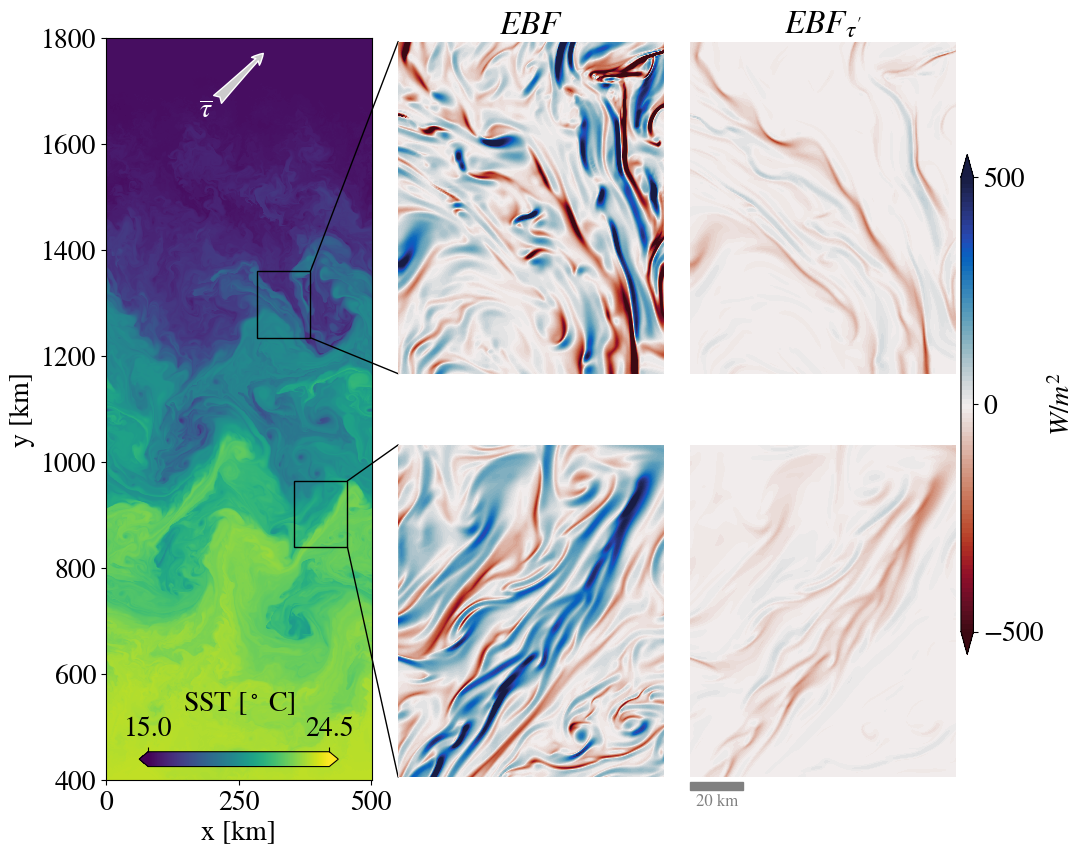

In [38]:
# Plot zooming in on the EBF and EBF'

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 20
rs = True
# Plot Vorticity
Day = 200
Day = 360+25
#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=False)

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 3)

## Large Map
###################################
axMap = fig.add_subplot(gs[:, 0])
btowatts=(1020*4000)/(2e-4*9.8)
vl = 15
vr = 24.5
EBF = (dsWC.EBF -dsWC.EBFm)
ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
label=r'SST [$^\circ$ C]'
axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

axins = inset_axes(axMap,
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='lower center')
cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
cb.set_label(label)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
axMap.set_xticks([0, 250, 500])
 
axMap.set_ylabel('y [km]')
axMap.set_xlabel('x [km]')

axMap.annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
               dict(arrowstyle='fancy', 
                    fc='0.8',
                    ec = 'w' ),
              color='w')
## First zoom
###################################
axZ1 = fig.add_subplot(gs[0, 1])
EBFprime = (dsWC.EBF )
vl = -500
vr = 500
#ix = axZ1.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ1.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
    
label=r'$\zeta/f$'
          
xlim = (270,370)
ylim = (1300,1425)
ylim = (1235, 1360); xlim=(285, 385)
axZ1.set_xlim(xlim)
axZ1.set_ylim(ylim)
axZ1.set_aspect('equal')
axZ1.set_title('$EBF$')
axZ1.set_axis_off()


## EBF Prime
###################################
axZ2 = fig.add_subplot(gs[0,2])
EBFprime = (dsWC.EBF - dsWC.EBFm)

ix = axZ2.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ2.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
    
label=r'$\zeta/f$'
        
axZ2.set_xlim(xlim)
axZ2.set_ylim(ylim)
axZ2.set_aspect('equal')
axZ2.set_title('$EBF_{\\tau^\prime}$')
axZ2.set_axis_off()
# Add the box on the main plot
rect = patches.Rectangle( (xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], edgecolor= 'k', facecolor='none')
axMap.add_patch(rect)

## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[1]], xyB=[xlim[0],ylim[1]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)


### DO IT AGAIN FOR THE OTHER PATCH
###################################
# First zoom
axZ1 = fig.add_subplot(gs[1, 1])
EBFprime = (dsWC.EBF )

#ix = axZ1.pcolor(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ1.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
    
#ix = axZ1.pcolormesh(dsWC.x_rho.isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2))/1000, dsWC.y_rho.isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2))/1000, btowatts*EBFprime.sel(ocean_time=Day*86400).isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2)), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)

label=r'$\zeta/f$'
          
xlim = (375,475)
ylim = (850,975)
ylim = (840, 965); xlim=(355, 455)
axZ1.set_xlim(xlim)
axZ1.set_ylim(ylim)
axZ1.set_aspect('equal')
axZ1.axis('off')

axZ2 = fig.add_subplot(gs[1,2])
EBFprime = (dsWC.EBF - dsWC.EBFm)

#ix = axZ2.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ2.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
label=r'$\zeta/f$'
        
axZ2.set_xlim(xlim)
axZ2.set_ylim(ylim)
axZ2.set_aspect('equal')
axZ2.set_axis_off()

# Add the box on the main plot
rect = patches.Rectangle( (xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], edgecolor= 'k', facecolor='none')
axMap.add_patch(rect)

## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[1]], xyB=[xlim[0],ylim[1]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)

### ADD COLORBAR
fig.subplots_adjust(right=0.975)
cbar_ax = fig.add_axes([0.98, 0.25, 0.0125, 0.5])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both', ticks=[-500, 0, 500])
cb.set_label('$W/m^2$')
cb.solids.set_edgecolor("face")

## FINAL CLEAN UP AND SAVING
plt.rcParams['font.size'] = 14
plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)


#Add scale bar
##############
rect = patches.Rectangle((xlim[0], ylim[0]-5), 20, 3, linewidth=1, edgecolor='0.5', facecolor='0.5', clip_on=False)
# Add the patch to the Axes
axZ2.add_patch(rect)

axZ2.annotate('20 km', xy=(xlim[0]+5, ylim[0]-8),  xycoords='data',
             xytext=(xlim[0]+2, ylim[0]-11), textcoords='data',
              color='0.5', fontsize=12,
#              arrowprops=dict(arrowstyle='-', facecolor='black'),
              annotation_clip=False
             )

#plt.savefig('../figures/EBFZooms_BFLUX.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Plot zooming in on the EBF and EBF'

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 20
rs = True
# Plot Vorticity
Day = 200
Day = 360+25
#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=False)

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 3)

templevels = np.linspace(15, 24, 10)
## Large Map
###################################
axMap = fig.add_subplot(gs[:, 0])
btowatts=(1020*4000)/(2e-4*9.8)
vl = -500
vr = 500
EBF = (dsWC.EBF)
# ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
ix = axMap.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBF.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axMap.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=0.5)

label=r'SST [$^\circ$ C]'
axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

axMap.set_ylim(400, 1800)
axMap.set_aspect('equal')

# axins = inset_axes(axMap,
#                     width="75%",  # width = 50% of parent_bbox width
#                     height="2%",  # height : 5%
#                     loc='lower center')
# cb = plt.colorbar(ix, ax=axMap, cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
# cb.set_label(label)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')
axMap.set_xticks([0, 250, 500])
 
axMap.set_ylabel('y [km]')
axMap.set_xlabel('x [km]')
axMap.set_title('$EBF$')
axMap.annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
               dict(arrowstyle='fancy', 
                    fc='0.8',
                    ec = 'k' ),
              color='k')
## First zoom
###################################
axZ1 = fig.add_subplot(gs[0, 1])
EBFprime = (dsWC.EBFm )
vl = -500
vr = 500
#ix = axZ1.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ1.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
ix = axZ1.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=1)
    
label=r'$\zeta/f$'
          
xlim = (270,370)
ylim = (1300,1425)
ylim = (1235, 1360); xlim=(285, 385)
axZ1.set_xlim(xlim)
axZ1.set_ylim(ylim)
axZ1.set_aspect('equal')
axZ1.set_title('$EBF_{\overline{\\tau}}$', pad = 8.5)
axZ1.set_axis_off()


## EBF Prime
###################################
axZ2 = fig.add_subplot(gs[0,2])
EBFprime = (dsWC.EBF - dsWC.EBFm)

ix = axZ2.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ2.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
ix = axZ2.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=1)
    
label=r'$\zeta/f$'
        
axZ2.set_xlim(xlim)
axZ2.set_ylim(ylim)
axZ2.set_aspect('equal')
axZ2.set_title('$EBF_{\\tau^\prime}$', pad = 8.5)
axZ2.set_axis_off()
# Add the box on the main plot
rect = patches.Rectangle( (xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], edgecolor= 'k', facecolor='none')
axMap.add_patch(rect)

## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[1]], xyB=[xlim[0],ylim[1]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)


### DO IT AGAIN FOR THE OTHER PATCH
###################################
# First zoom
axZ1 = fig.add_subplot(gs[1, 1])
EBFprime = (dsWC.EBFm )

#ix = axZ1.pcolor(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ1.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
ix = axZ1.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=1)
   
#ix = axZ1.pcolormesh(dsWC.x_rho.isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2))/1000, dsWC.y_rho.isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2))/1000, btowatts*EBFprime.sel(ocean_time=Day*86400).isel(xi_rho=slice(375*2, 475*2), eta_rho=slice(850*2, 975*2)), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)

label=r'$\zeta/f$'
          
xlim = (375,475)
ylim = (850,975)
ylim = (840, 965); xlim=(355, 455)
axZ1.set_xlim(xlim)
axZ1.set_ylim(ylim)
axZ1.set_aspect('equal')
axZ1.axis('off')

axZ2 = fig.add_subplot(gs[1,2])
EBFprime = (dsWC.EBF - dsWC.EBFm)

#ix = axZ2.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
ix = axZ2.contourf(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
for pathcoll in ix.collections:
    pathcoll.set_rasterized(rs)
ixd = axZ2.contour(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),levels = templevels, colors='0.75', alpha=0.75, linewidths=1)
        
axZ2.set_xlim(xlim)
axZ2.set_ylim(ylim)
axZ2.set_aspect('equal')
axZ2.set_axis_off()

# Add the box on the main plot
rect = patches.Rectangle( (xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], edgecolor= 'k', facecolor='none')
axMap.add_patch(rect)

## ADD CONNECTION LINES
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[1]], xyB=[xlim[0],ylim[1]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)
con = patches.ConnectionPatch(xyA=[xlim[1],ylim[0]], xyB=[xlim[0],ylim[0]], coordsA="data", coordsB="data",
                      axesA=axMap, axesB=axZ1, color='k')
axMap.add_artist(con)

### ADD COLORBAR
fig.subplots_adjust(right=0.975)
cbar_ax = fig.add_axes([0.98, 0.25, 0.0125, 0.5])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both', ticks=[-500, 0, 500])
cb.set_label('$W/m^2$')
cb.solids.set_edgecolor("face")

## FINAL CLEAN UP AND SAVING
plt.rcParams['font.size'] = 14
plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)


#Add scale bar
##############
rect = patches.Rectangle((xlim[0], ylim[0]-5), 20, 3, linewidth=1, edgecolor='0.5', facecolor='0.5', clip_on=False)
# Add the patch to the Axes
axZ2.add_patch(rect)

axZ2.annotate('20 km', xy=(xlim[0]+5, ylim[0]-8),  xycoords='data',
             xytext=(xlim[0]+2, ylim[0]-11), textcoords='data',
              color='0.5', fontsize=12,
#              arrowprops=dict(arrowstyle='-', facecolor='black'),
              annotation_clip=False
             )

plt.savefig('../figures/EBFZooms_New_BFLUX.pdf', bbox_inches='tight', dpi=450)

In [49]:
np.linspace(15, 24, 10)

array([15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [95]:
# Print out some relevant values for the manuscript
# Recall positive is defined out of the ocean...
print(f'Maximum EBF anywhere: {btowatts*dsWC.EBF.sel(ocean_time=Day*86400).max().values} W/m2')
print(f'Minimum EBF anywhere: {btowatts*dsWC.EBF.sel(ocean_time=Day*86400).min().values} W/m2')

#Domain 1
ylim = (1235, 1360); xlim=(285, 385)
EBFzoom = dsWC.EBF.sel(ocean_time=Day*86400).isel( eta_rho=slice(int(ylim[0]*2), int(ylim[1]*2)), xi_rho=slice(int(xlim[0]*2), int(xlim[-1]*2)))
EBFzoomprime = (dsWC.EBF - dsWC.EBFm).sel(ocean_time=Day*86400).isel( eta_rho=slice(int(ylim[0]*2), int(ylim[1]*2)), xi_rho=slice(int(xlim[0]*2), int(xlim[-1]*2)))
#plt.contourf(btowatts*EBFzoom, levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
#plt.axis('equal')
print('\nDomain 1')
print(f'Maximum EBF in zoom: {btowatts*EBFzoom.max().values} W/m2')
print(f'Minimum EBF in zoom: {btowatts*EBFzoom.min().values} W/m2')
print(f'Maximum EBF\' in zoom: {btowatts*EBFzoomprime.max().values} W/m2')
print(f'Minimum EBF\' in zoom: {btowatts*EBFzoomprime.min().values} W/m2')
print(f'Reduction in max: {(EBFzoomprime.min()/EBFzoom.max()).values}')

#Domain 2
ylim = (840, 965); xlim=(355, 455)
EBFzoom = dsWC.EBF.sel(ocean_time=Day*86400).isel( eta_rho=slice(int(ylim[0]*2), int(ylim[1]*2)), xi_rho=slice(int(xlim[0]*2), int(xlim[-1]*2)))
EBFzoomprime = (dsWC.EBF - dsWC.EBFm).sel(ocean_time=Day*86400).isel( eta_rho=slice(int(ylim[0]*2), int(ylim[1]*2)), xi_rho=slice(int(xlim[0]*2), int(xlim[-1]*2)))
#plt.contourf(btowatts*EBFzoom, levels = np.linspace(vl, vr, 100), extend='both', cmap = cmo.balance_r)
#plt.axis('equal')
print('\nDomain 2')
print(f'Maximum EBF in zoom: {btowatts*EBFzoom.max().values} W/m2')
print(f'Minimum EBF in zoom: {btowatts*EBFzoom.min().values} W/m2')
print(f'Maximum EBF\' in zoom: {btowatts*EBFzoomprime.max().values} W/m2')
print(f'Minimum EBF\' in zoom: {btowatts*EBFzoomprime.min().values} W/m2')
print(f'Reduction in max: {(EBFzoomprime.min()/EBFzoom.max()).values}')

Maximum EBF anywhere: 1872.9856144406708 W/m2
Minimum EBF anywhere: -5101.631990216947 W/m2

Domain 1
Maximum EBF in zoom: 1239.3021344386004 W/m2
Minimum EBF in zoom: -4029.1287293758623 W/m2
Maximum EBF' in zoom: 97.53503082738831 W/m2
Minimum EBF' in zoom: -360.20099621370656 W/m2
Reduction in max: -0.2906482517719269

Domain 2
Maximum EBF in zoom: 914.1916363511639 W/m2
Minimum EBF in zoom: -666.8473168488439 W/m2
Maximum EBF' in zoom: 60.28565445487809 W/m2
Minimum EBF' in zoom: -227.3344349231017 W/m2
Reduction in max: -0.24867261946201324


## Zoom on Eddy

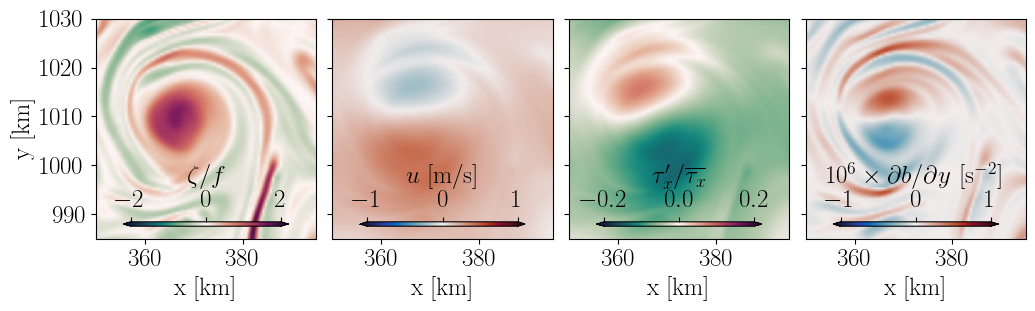

In [38]:
# Nice side-by-side SST, vorticity, stress perturbation plot
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
rs = True
# Plot Vorticity
Day = 200
#Day = 185
Day = 360+25
fig, ax = plt.subplots(1,4, figsize=(12, 3), sharey=True)


# Divergence
#divnorm = dsWC.div.isel(s_rho=-3).sel(ocean_time=Day*86400)/dsWC.f
#ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, divnorm, vmin=-1, vmax=1, cmap = cmo.curl)

#ax[2].set_ylim(300, 1900)
#ax[2].set_aspect('equal')


# Iterate through subplots
for i in range(0,4):
    if i==3:
#         vl = 18
#         vr = 22
#         ix = ax[0].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = 'viridis', rasterized=rs, shading='gouraud')
#         label=r'SST [$^\circ$ C]'
          vl = -1
          vr = 1
          ix = ax[i].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, 1e6*dsWC.by.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance, rasterized=rs, shading='gouraud')
          label=r'$10^6 \times \partial b/\partial y$ [s$^{-2}$] '
    elif i==0:
        vl = -2
        vr = 2
        vortnorm = xroms.to_rho(dsWC.vort.isel(s_rho=-1).sel(ocean_time=Day*86400), grid)/dsWC.f
        ix = ax[i].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, vortnorm, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs, shading='gouraud')
        label=r'$\zeta/f$'
    elif i==1:
        vl = -1
        vr = 1
        vortnorm = xroms.to_rho(dsWC.u.isel(s_rho=-1).sel(ocean_time=Day*86400), grid)
        ix = ax[i].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, vortnorm, vmin=vl, vmax=vr, cmap = cmo.balance, rasterized=rs, shading='gouraud')
        label=r'$u$ [m/s]'
    elif i==2:
        vl = -0.2
        vr = 0.2
        label = r'$\tau_x^\prime/\overline{\tau_x}$'
        txmag = (1e-3*np.sqrt(2*5**2)*5)
        txpert = (dsWC.sustr.sel(ocean_time=Day*86400) - txmag)/txmag
        txpert = xroms.to_rho(txpert, grid)
        ix = ax[i].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, txpert, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs, shading='gouraud')

    
    ax[i].set_xlim(335, 410)
    ax[i].set_ylim(965, 1040)
    
    #Testing
    ax[i].set_ylim(970, 1035)
    ax[i].set_xlim(335, 400)
    
    #Testing eddy focus
    ax[i].set_ylim(985, 1030)
    ax[i].set_xlim(350, 395)
    ax[i].set_aspect('equal')

    axins = inset_axes(ax[i],
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='lower center')
    cb = plt.colorbar(ix, ax=ax[i], cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
    cb.set_label(label, labelpad=5)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    #ax[i].set_xticks([0, 250, 500])

ax[0].set_ylabel('y [km]')
ax[0].set_xlabel('x [km]')
ax[1].set_xlabel('x [km]')
ax[2].set_xlabel('x [km]')
ax[3].set_xlabel('x [km]')

cf = 100 # 20 is 10 km
xslice = slice(0, 1000, cf)
yslice = slice(0, 4000, cf)
#suc = xroms.to_rho(dsWC.sustr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
#svc = xroms.to_rho(dsWC.svstr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
#xrhoc = dsWC.x_rho.isel(xi_rho=xslice, eta_rho=yslice)

#ax[2].quiver(xrhoc.x_rho/1000, xrhoc.y_rho/1000, suc, svc)
#ax[2].quiver(200, 1600, txmag, txmag, scale=2e-1)
#ax[2].annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
#               dict(arrowstyle='fancy', 
#                    fc='0.8',
#                    ec = 'k'))
plt.subplots_adjust(wspace=0.075)

plt.rcParams['font.size'] = 14
#plt.savefig('../figures/EddyZoom_BFLUX.pdf', bbox_inches='tight', dpi=450)

In [42]:
# print average ebf' and ebfm over the eddy.
ylim = slice(990*2, 1025*2)
xlim = slice(350*2, 380*2)
Day = 360+25
btowatts=(1020*4000)/(2e-4*9.8)


EBFprime = (dsWC.EBF - dsWC.EBFm)
epm = EBFprime.sel(ocean_time=Day*86400).isel(eta_rho=ylim, xi_rho=xlim).mean()
emm = dsWC.EBFm.sel(ocean_time=Day*86400).isel(eta_rho=ylim, xi_rho=xlim).mean()

print(f'Mean EBFprime is {epm.values*btowatts}')
print(f'Mean EBFmean is {emm.values*btowatts}')

Mean EBFprime is -6.845807485515181
Mean EBFmean is -1.1776635721027595


## Histograms

In [9]:
ny = np.array(dsWC.eta_rho.size)
nyc = int(ny/2)
nysp = int(ny/6) #Histograms are in the middle 1/3 of the domain.
yl = slice(nyc-nysp, nyc+nysp)


In [ ]:
# Vorticity/Div/Strain Histogram, manual, fancy plotting
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3,figsize=(16,7), sharey=True)
sl = -2
#sl = -1
tl = 25  # time index to start at (goes to end)|

dens = False # normalize
# Vorticity
bins = np.linspace(-2, 2.5, 100)
f_psi = xroms.to_psi(dsWC.f, gridWC)
hist, binedges = np.histogram((dsWC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=tl, eta_v=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=tl, eta_v=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm


left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[0].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')
ax[0].step(centers, histnc,  linewidth=3, color='#ff7f0e')
# ax[0].hist((dsWC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=range(tl,-1), eta_v=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#1f77b4');
# ax[0].hist((dsNC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=range(tl,-1), eta_v=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#ff7f0e', histtype='step', linewidth=3);
ax[0].set_xlabel('$\zeta/f$')
ax[0].set_ylabel('Frequency')
ax[0].grid()
ax[0].set_title('Vorticity')
ax[0].set_ylabel('Normalized frequency')
ax[0].set_xlim(bins[0], bins[-1])

# # Divergence
bins = np.linspace(-1, 1, 100)
f_rho = dsWC.f

hist, binedges = np.histogram((dsWC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm

left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[1].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')

ax[1].step(centers, histnc,  linewidth=3, color='#ff7f0e')

#ax[1].hist((dsWC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#1f77b4');
#ax[1].hist((dsNC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#ff7f0e', histtype='step', linewidth=3);
ax[1].set_xlabel('$\delta/f$')
#ax[1].set_ylabel('Frequency')
ax[1].grid()
ax[1].set_title('Horizontal divergence')
ax[1].set_xlim(bins[0], bins[-1])

# Strain
bins = np.linspace(0, 2.5, 100)
f_rho = dsWC.f

hist, binedges = np.histogram((dsWC.strain/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.strain/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm
left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[2].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')
ax[2].step(centers, histnc,  linewidth=3, color='#ff7f0e')

ax[2].set_xlabel('$\\alpha/f$')
#ax[2].set_ylabel('Frequency')
ax[2].grid()
ax[2].set_title('Strain')
ax[2].set_xlim(bins[0], bins[-1])

plt.tight_layout()

# plt.savefig(f'../figures/Histograms_BFLUX.pdf', bbox_inches='tight')

In [ ]:
# Vorticity/Div/Strain Histogram, manual, fancy plotting
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3,figsize=(16,7), sharey=True)
sl = -2
#sl = -1
tl = 25  # time index to start at (goes to end)|

dens = False # normalize
# Vorticity
bins = np.linspace(-2, 2.5, 100)
f_psi = xroms.to_psi(dsWC.f, gridWC)
hist, binedges = np.histogram((dsWC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=tl, eta_v=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=tl, eta_v=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm


left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[0].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')
ax[0].step(centers, histnc,  linewidth=3, color='#ff7f0e')
# ax[0].hist((dsWC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=range(tl,-1), eta_v=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#1f77b4');
# ax[0].hist((dsNC.vort/f_psi).isel(s_rho=range(sl,0), ocean_time=range(tl,-1), eta_v=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#ff7f0e', histtype='step', linewidth=3);
ax[0].set_xlabel('$\zeta/f$')
ax[0].set_ylabel('Frequency')
ax[0].grid()
ax[0].set_title('Vorticity')
ax[0].set_ylabel('Normalized frequency')
ax[0].set_xlim(bins[0], bins[-1])

# # Divergence
bins = np.linspace(-1, 1, 100)
f_rho = dsWC.f

hist, binedges = np.histogram((dsWC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm

left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[1].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')

ax[1].step(centers, histnc,  linewidth=3, color='#ff7f0e')

#ax[1].hist((dsWC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#1f77b4');
#ax[1].hist((dsNC.div/f_rho).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins, alpha=0.5, density=dens, color='#ff7f0e', histtype='step', linewidth=3);
ax[1].set_xlabel('$\delta/f$')
#ax[1].set_ylabel('Frequency')
ax[1].grid()
ax[1].set_title('Horizontal divergence')
ax[1].set_xlim(bins[0], bins[-1])

# Strain
bins = np.linspace(0, 2.5, 100)
f_rho = dsWC.f

hist, binedges = np.histogram((dsWC.Nablab/f_rho**2).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
histnc, binedges = np.histogram((dsNC.Nablab/f_rho**2).isel(s_rho=range(sl,0), ocean_time=tl, eta_rho=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm
left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
ax[2].bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')
ax[2].step(centers, histnc,  linewidth=3, color='#ff7f0e')

ax[2].set_xlabel('$\\alpha/f$')
#ax[2].set_ylabel('Frequency')
ax[2].grid()
ax[2].set_title('Strain')
ax[2].set_xlim(bins[0], bins[-1])

plt.tight_layout()

# plt.savefig(f'../figures/Histograms_BFLUX.pdf', bbox_inches='tight')

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


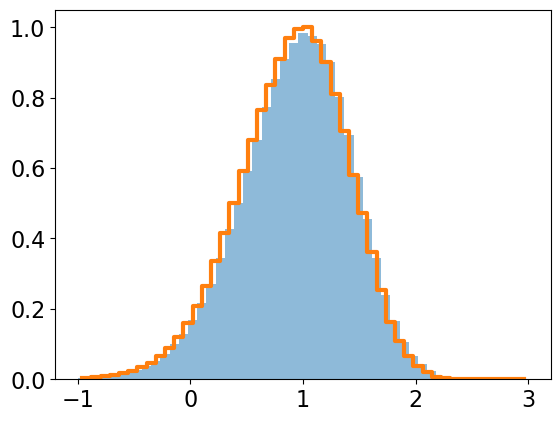

In [23]:
sl = -2
#sl = -1
tl = 25  # time index to start at (goes to end)|
yl
plt.rcParams['text.usetex'] = False
f_rho = dsWC.f
bins = np.linspace(0, 50, 100)
bins = np.log10(np.logspace(-1, 3))
hist, binedges = np.histogram(np.log10(dsWC.Nablab/f_rho**2).isel(ocean_time=tl, eta_rho=yl).values.ravel(), bins)
histnc, binedges = np.histogram(np.log10(dsNC.Nablab/f_rho**2).isel( ocean_time=tl, eta_rho=yl).values.ravel(), bins)
norm = np.max([np.max(hist), np.max(histnc)])
hist = hist/norm
histnc = histnc/norm
left_edges = binedges[:-1]
width = 1*(left_edges[1] - left_edges[0])
centers = left_edges + width/2
plt.bar(left_edges, hist, alpha=0.5, align='edge', width=width, color='#1f77b4')
plt.step(centers, histnc,  linewidth=3, color='#ff7f0e')
# plt.plot(left_edges, hist)

In [39]:
(dsWC.hbl).mean().values/(dsNC.hbl).mean().values

0.9955339

In [38]:
np.median(dsNC.Nablab.values)/np.median(dsWC.Nablab.values)

1.0414946